In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib


# Notification
import time

# File IO
import h5py
import os

# Deep learning
# Keras-related imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution1D, MaxPooling2D, Convolution2D
from keras import backend as K
# K.set_image_dim_ordering('th')
from keras.callbacks import ModelCheckpoint
from keras.callbacks import RemoteMonitor
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D


# Result processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score


2023-04-24 12:03:28.401660: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-24 12:03:28.597854: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-24 12:03:28.600034: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 12:03:30.128552: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Section 0: Perform feature transform, save data

This section is used to create the $(\mathbf{X},y)$ training set with feature choice parameterised by either `{'log-mel', 'mfcc'}`. Librosa is used to extract the features, and has further support for any features one may wish to choose.

Once this section has been run once, the user is advised to skip to **Section 1** which deals with performing a baseline classification using a Convolutional Neural Network.

In [2]:
# Parameterise feature transform here. The default is to use log-mel features, but the user may implement any choice
# or use the raw time-series as preferred 

feature_type = 'log-mel'  # Select from {'log-mel', 'mfcc'}


win_len = 0.1  # Window length of feature
n_mels = 128  # Number of log-mel coefficients

In [3]:
# Select the root of the processed 1 second audio chunks, where votes have been aggregated already
# This path is relative, and should by default point to the correct location

wav_root = '../data/audio_1sec/'  

In [4]:
# Load the label information contained in the resolved 1 second chunks, with votes {'yes', 'no', 'not_sure'}

df = pd.read_csv('../labels/audio_1sec.csv',  header=None, names=["path", "yes", "no", "not_sure","subject_set"])
df['path'] = df['path'].astype(str) + '.wav'


# Create the y vector by treating 'not_sure' as 0.5, 'yes' as 1.0, 'no' as 0.0 and average
df['res'] = (df['yes'].astype(int)*1 + df['not_sure'].astype(int)*0.5) / (df['yes'] + df['no'] + df['not_sure']) >= 0.5
total_audio_n = len(df.index.values.tolist())

y = np.zeros((total_audio_n, 2))

y[:,1] = np.array(np.array(df['res']).astype(int)).astype(int)
y[:,0] = 1-y[:,1].astype(int)

In [5]:
# Initialise dimensions for feature transformation

nfft = int(win_len * 8000)
wav_path = wav_root + df["path"]

# Initialise empty X matrix
wav, fs = librosa.load(wav_path.iloc[0],sr=None)  # Load one spectrogram file to calculate dimensions of entire set

if feature_type == 'log-mel':    
    spec = librosa.feature.melspectrogram(y=wav, sr=fs, n_mels=n_mels, n_fft=nfft*4, hop_length=nfft)
             
elif feature_type == 'mfcc':
    spec = librosa.feature.mfcc(y=wav, sr=fs, n_mfcc=13, n_fft=nfft*4, hop_length=nfft)
    
l_spec = np.shape(spec)[1]  # Length of the spectral representation for each 2 second chunk
h_spec = np.shape(spec)[0]  # This is also n_mels
spec_matrix = np.zeros([len(y), h_spec, l_spec])  

In [6]:
# Perform feature transformation and store result in pre-allocated spec_matrix

start_time = time.time()
for i in range(0, total_audio_n):
#     if count[i] == 1:
        
        # Create X matrix
    audio_file, fs = librosa.load(wav_path.loc[i],sr=None)
    if feature_type == 'log-mel':
        spec_matrix[i] = librosa.feature.melspectrogram(y=audio_file,
                                                        sr=fs, n_mels=n_mels, n_fft=nfft*4, hop_length=nfft)

    elif feature_type == 'mfcc':
        spec_matrix[i] = librosa.feature.mfcc(y=audio_file,
                                                        sr=fs, n_mfcc=13, n_fft=nfft*4, hop_length=nfft)            
        
    if i%1000 == 0:
        time_used = time.time()-start_time
        time_total = time_used * total_audio_n / (i+1)
        
        print('Iteration', str(i), "%i"%(time_used), "%i"%(time_total))



Iteration 0 0 2054
Iteration 1000 14 1181
Iteration 2000 28 1118
Iteration 3000 40 1061
Iteration 4000 53 1059
Iteration 5000 64 1030
Iteration 6000 76 1021
Iteration 7000 89 1017
Iteration 8000 102 1025
Iteration 9000 115 1024
Iteration 10000 127 1019
Iteration 11000 141 1022
Iteration 12000 152 1014
Iteration 13000 165 1011
Iteration 14000 176 1006
Iteration 15000 189 1006
Iteration 16000 200 998
Iteration 17000 211 990
Iteration 18000 221 982
Iteration 19000 234 981
Iteration 20000 246 980
Iteration 21000 258 979
Iteration 22000 270 979
Iteration 23000 283 980
Iteration 24000 295 980
Iteration 25000 309 986
Iteration 26000 321 983
Iteration 27000 333 984
Iteration 28000 342 974
Iteration 29000 349 960
Iteration 30000 359 953
Iteration 31000 375 964
Iteration 32000 388 967
Iteration 33000 401 969
Iteration 34000 412 966
Iteration 35000 423 963
Iteration 36000 431 955
Iteration 37000 440 948
Iteration 38000 450 943
Iteration 39000 459 938
Iteration 40000 469 934
Iteration 41000 478 93

In [8]:
# Save files with file_name if not in path

file_names = ['data_log-melnot_sure_single_into_0_5.h5', 'label_log-melnot_sure_single_into_0_5.h5']

for file_name in file_names:
    if not os.path.isfile('../proc_data/' + file_name):
        hf = h5py.File('../proc_data/data_' + feature_type + 'not_sure_single_into_0_5.h5', 'w')
        hf.create_dataset('../proc_data/data_' + feature_type + '_majority_labels_not_sure_single_into_0_5',
                          data=spec_matrix)
        hf.close()
        
        hf = h5py.File('../proc_data/label_' + feature_type + 'not_sure_single_into_0_5.h5', 'w')
        hf.create_dataset('../proc_data/label_' + feature_type + '_majority_labels_not_sure_single_into_0_5', data=y)
        hf.close()

# Section 1: Load and classify

If the feature transform has already been performed and the data is saved in `proc_data`, load the data in the cell below and perform classification as outlined by the following cells.

In [9]:
# Load files
feature_type = 'log-mel'
save_name = 'not_sure_single_into_0_5'

hf = h5py.File('../proc_data/data_' + feature_type + save_name + '.h5', 'r')
spec_matrix_read = np.array(hf.get('../proc_data/data_' + feature_type + '_majority_labels_' + save_name))
hf.close()

hf = h5py.File('../proc_data/label_' + feature_type + save_name + '.h5', 'r')
y = np.array(hf.get('../proc_data/label_' + feature_type + '_majority_labels_' + save_name))
hf.close()


# Create dataset 


In [10]:
# Convert to dB

spec_matrix_db = np.zeros_like(spec_matrix_read)

for i, spec in enumerate(spec_matrix_read):
    spec_matrix_db[i] = librosa.power_to_db(spec,ref=np.max)

## Train Convolutional Neural Network

First, the data is split tenfold using `sklearn`'s `train_test_split` with the random states given in the `random_state` vector.

The neural network cross-entropy weights are set in the dictionary `class_weight`, with the key `0` referring to the noise class, and `1` referring to the mosquito class

In [14]:
pred_list = []
y_test_list = []

for random_state in [10,20,30,40,50,60,70,80,90,100]:

     X_train, X_test, y_train, y_test = train_test_split(spec_matrix_db, np.array(y), test_size=0.33,
                                                            random_state=random_state)
     # Normalise by statistics of training data
     print(1)
     X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)
     X_test_norm = (X_test - np.mean(X_train))/np.std(X_train)
     X_train_tf = X_train_norm.reshape(X_train_norm.shape[0], 1, X_train_norm.shape[1], X_train_norm.shape[2])
     X_test_tf = X_test_norm.reshape(X_test_norm.shape[0], 1, X_test_norm.shape[1], X_test_norm.shape[2])

     ################################ CONVOLUTIONAL NEURAL NETWORK ################################
     ## NN parameters
     class_weight = {0: 1.,
                         1: 10.,
                         }
     input_shape = (1, X_train_tf.shape[2], X_train_tf.shape[-1])
     print(1)
     model = Sequential()
     print(2)
     n_dense = 128
     nb_classes = 2
     # number of convolutional filters
     nb_conv_filters = 32
     nb_conv_filters_2 = 64
     input_shape = (128, 32, 1)

     model = Sequential()
     model.add(Conv2D(nb_conv_filters, kernel_size=(3, 3),
                    activation='relu', padding='same', strides=1,
                    input_shape=input_shape))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Conv2D(nb_conv_filters_2, kernel_size=(3, 3),
                    activation='relu', padding='same'))
     model.add(MaxPooling2D(pool_size=(2, 2)))
     model.add(Flatten())
     model.add(Dense(128, activation='relu'))
     model.add(Dropout(0.5))
     model.add(Dense(1, activation='sigmoid'))

     model.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

     model.fit(x=X_train_tf, y=y_train, batch_size=None, epochs=3, verbose=1, callbacks=None, validation_split=0.0,
              validation_data=None,
              shuffle=True, class_weight=class_weight, sample_weight=None, initial_epoch=0,
              steps_per_epoch=None, validation_steps=None)


     loss, acc = model.evaluate(x=X_test_tf, y=y_test, batch_size=None, verbose=0, sample_weight=None, steps=None)
     pred = model.predict(X_test_tf)
     plt.hist(pred[:,1]) # Optional: visualise histogram of labels
     #     plt.show()
     print(random_state, loss, acc)
     
     pred_list.append(pred)  # Collect y_test to report classification performance
     y_test_list.append(y_test)  # Collect y_test to report classification performance

    
    

1
1
2


2023-04-24 12:27:23.974217: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 300596736 exceeds 10% of free system memory.


Epoch 1/3


ValueError: in user code:

    File "/home/pluto/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/pluto/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/pluto/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/pluto/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/pluto/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/pluto/.local/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 128, 32, 1), found shape=(None, 1, 128, 11)


## Create plotting functions

We now create a function to display the confusion matrices. This is a slight modification of the `plot_confusion_matrix` function available on [sklearn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html) to include a mean and variance, for the purpose of evaluation over a tenfold split.

In [6]:
def plot_confusion_matrix(cm, classes, std,
                          normalize=False,
                                                    cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """


    std = std * 100
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] *100
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#     ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,

           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt) + ' ± ' + format(std[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


cm_list = []
for i in np.arange(len(pred_list)):
        cm_list.append(confusion_matrix(np.argmax(y_test_list[i],-1), np.argmax(pred_list[i],-1)))
cm_mean = np.mean(cm_list, axis = 0)
total = np.sum(cm_mean)
cm_mean = cm_mean/total
cm_std = np.std(cm_list, axis = 0)/total


## Format and display plot

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Normalized confusion matrix
[[85.36 14.64]
 [29.04 70.96]]


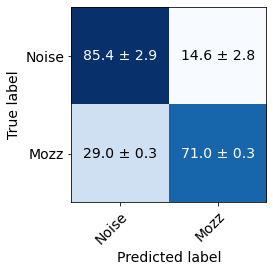

In [7]:
np.set_printoptions(precision=2)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)


class_names= np.array(['Noise', 'Mozz'])

# Plot normalized confusion matrix
plot_confusion_matrix(cm_mean, std=cm_std, classes=class_names, normalize=True)
plt.tight_layout()
plt.show()